# Task 1

# SVC

### Initialization

In [25]:
%matplotlib inline
import numpy as np
import math
import h5py
import random
import pyJHTDB
import time as tt
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import filters
import skimage.morphology as morphology
from skimage.morphology import square
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from matplotlib import cm
import scipy.io as sio
import time
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Ridge,RidgeCV,RidgeClassifierCV
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold # import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.family':"Times New Roman"}
pylab.rcParams.update(params)

# load shared library
lTDB = pyJHTDB.libJHTDB()
#initialize webservices
lTDB.initialize()

#Add token
auth_token  = "edu.jhu.burgers-2e898d7f"
lTDB.add_token(auth_token)

dataset = 'transition_bl'

spatialInterp  = 0  # no spatial interpolation
temporalInterp = 0  # no time interpolation
FD4NoInt       = 40 # 4th-order FD, no spatial interpolation

### Get training and test data

In [2]:
#Read Training and Test data
data_t0 = h5py.File('data_t0_TNT_45x30x48.h5','r')
data_t1000 = h5py.File('data_t1000_TNT_45x30x48.h5','r')
Z=data_t0['Z']
X=data_t0['X']
Y=data_t0['Y']
x=X[1,:,1]
y=Y[:,1,1]
z=Z[1,1,:]

### Display data label

In [3]:
list(data_t0.keys())

['TNT',
 'X',
 'Y',
 'Z',
 'dudx',
 'dudy',
 'dudz',
 'dvdx',
 'dvdy',
 'dvdz',
 'dwdx',
 'dwdy',
 'dwdz',
 'u',
 'up',
 'v',
 'vp',
 'w',
 'x',
 'y']

### Training ($t=0$) and Test ($t=1000$) data

In [4]:
niy=Z.shape[0]
nix=Z.shape[1]
niz=Z.shape[2]
X_t0=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t0_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t0=np.zeros((nix*niy*niz,1),dtype=np.float64)
X_t1000=np.zeros((nix*niy*niz,16),dtype=np.float64)
y_t1000_TNT=np.zeros((nix*niy*niz,1),dtype=object)
y_t1000=np.zeros((nix*niy*niz,1),dtype=np.float64)

X_t0[:,0]=data_t0['u']
X_t0[:,1]=data_t0['v']
X_t0[:,2]=data_t0['w']
X_t0[:,3]=data_t0['up']
X_t0[:,4]=data_t0['vp']
X_t0[:,5]=data_t0['dudx']
X_t0[:,6]=data_t0['dudy']
X_t0[:,7]=data_t0['dudz']
X_t0[:,8]=data_t0['dvdx']
X_t0[:,9]=data_t0['dvdy']
X_t0[:,10]=data_t0['dvdz']
X_t0[:,11]=data_t0['dwdx']
X_t0[:,12]=data_t0['dwdy']
X_t0[:,13]=data_t0['dwdz']
X_t0[:,14]=data_t0['x']
X_t0[:,15]=data_t0['y']
y_t0_TNT[:,0]=data_t0['TNT']

X_t1000[:,0]=data_t1000['u']
X_t1000[:,1]=data_t1000['v']
X_t1000[:,2]=data_t1000['w']
X_t1000[:,3]=data_t1000['up']
X_t1000[:,4]=data_t1000['vp']
X_t1000[:,5]=data_t1000['dudx']
X_t1000[:,6]=data_t1000['dudy']
X_t1000[:,7]=data_t1000['dudz']
X_t1000[:,8]=data_t1000['dvdx']
X_t1000[:,9]=data_t1000['dvdy']
X_t1000[:,10]=data_t1000['dvdz']
X_t1000[:,11]=data_t1000['dwdx']
X_t1000[:,12]=data_t1000['dwdy']
X_t1000[:,13]=data_t1000['dwdz']
X_t1000[:,14]=data_t1000['x']
X_t1000[:,15]=data_t1000['y']
y_t1000_TNT[:,0]=data_t1000['TNT']

### One-Hot encoding

In [5]:
# One-Hot encoding of t0ing data
onehot_encoder = OneHotEncoder()
onehot_encoded = onehot_encoder.fit_transform(y_t0_TNT).toarray()
y_t0[:,0]=onehot_encoded[:,0]
if y_t0_TNT[0] == 'NT' and y_t0[0,0] == 1.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
if y_t0_TNT[0] == 'T' and y_t0[0,0] == 0.:
    print('Making sure T=1 and NT=0 in training data:')
    y_t0=1-y_t0
    
# One-Hot encoding of t1000 data
onehot_encoded = onehot_encoder.fit_transform(y_t1000_TNT).toarray()
y_t1000[:,0]=onehot_encoded[:,0]
if y_t1000_TNT[0] == 'NT' and y_t1000[0,0] == 1.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000
if y_t1000_TNT[0] == 'T' and y_t1000[0,0] == 0.:
    print('Making sure T=1 and NT=0 in test data:')
    y_t1000=1-y_t1000

y_t0=y_t0.ravel()
y_t1000=y_t1000.ravel()

Making sure T=1 and NT=0 in training data:
Making sure T=1 and NT=0 in test data:


### Standardize features 

In [6]:
# Standarize features
scaler = StandardScaler()
X_t0_std = scaler.fit_transform(X_t0)
X_t1000_std = scaler.fit_transform(X_t1000)

### SVC with hyper parameter tuning with GridsearchCV

In [8]:
# defining parameter range 
param_grid = {'C': [0.01,0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 10,cv=3,n_jobs=2)
# fitting the model for grid search 
grid.fit(X_t0_std, y_t0) 
print("SVC after hyper-parameter tuning")
# print best parameter after tuning 
print(grid.best_params_)
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 
grid_predictions = grid.predict(X_t1000_std)
print(metrics.classification_report(y_t1000, grid_predictions)) 
print('Mean square error',metrics.mean_squared_error(y_t1000,grid_predictions))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   39.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   46.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  4.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  7.2min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  7.7min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 10.2min
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed: 10.8min finished


SVC after hyper-parameter tuning
{'C': 10, 'gamma': 1, 'kernel': 'linear'}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54729
         1.0       1.00      0.98      0.99     10071

   micro avg       1.00      1.00      1.00     64800
   macro avg       1.00      0.99      0.99     64800
weighted avg       1.00      1.00      1.00     64800

Mean square error 0.0026697530864197533


### Prediction using test data $(t=1000)$

In [9]:
#Prediction on test data
y_pred= grid_predictions.reshape((niy,niz,nix))
y_t1000= y_t1000.reshape((niy,niz,nix))

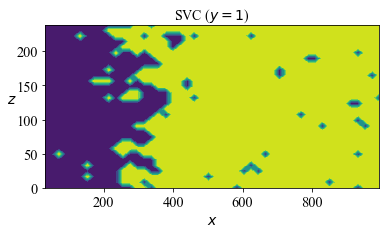

In [26]:
plt.figure(figsize=(6,3));
plt.contourf(x,z,y_pred[2,:,:])
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$z$',rotation=0, fontsize=14)
plt.title("SVC ($y=1$)", fontsize=14)
plt.ylim(z[0],z[niz-1])
plt.savefig('SVC.png',dpi=300)

###  Report mean squared error

In [12]:
#Mean squared error
metrics.mean_squared_error(y_pred.flatten(),y_t1000.flatten())

0.0026697530864197533